In [6]:
from editor import Editor
from Box2D.b2 import pi

# edit your model by running this cell
# hit 's' to save while editing to model.json

editor = Editor()
editor.load('two_legs.json')
editor.run()

File saved as: two_legs.json


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from IPython.display import clear_output

import pygame
from pygame.locals import (KEYDOWN, K_RIGHT, K_LEFT, K_r, K_s)

from Box2D.b2 import pi

from agent import Agent
from engine import Engine

from time import sleep

# train your model to (hopefully) walk by running this cell
FILE = 'two_legs.json'

TIMESTEPS = 500 # timesteps per episode

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True

ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0
engine = Engine(caption='Train', width=800, height=600, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, linear_damping=0.0, angular_damping=0.0)

engine.load(FILE)

# Add floor
engine.add_static_body(p=(engine.width/2, engine.height-10), size=(engine.width, 10))

# Features
ENCODING_SIZE = 32 # buckets for body angles

def features(time_step=0):
    f = []
    """
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = int(a * ENCODING_SIZE)
            encoding = [0] * ENCODING_SIZE
            encoding[a] = 1.0
            f.extend(encoding)"""
    
    
    for b in engine.world.bodies:
        if b.userData and isinstance(b.userData, dict):
            a = b.angle % ANGLE_RANGE
            a /= ANGLE_RANGE
            a = a * 2.0 - 1.0
            f += [a]
            f += [(engine.height - engine.to_screen(b.position)[0])/engine.height]
            #f += [np.sin(a), np.cos(a)]
            #f += [b.angularVelocity]
            #f += [b.linearVelocity[0]]
            #f += [b.linearVelocity[1]]
            
    
    #f += [float(time_step/TIMESTEPS * 2.0 - 1.0)]
    #f.append(np.sin(time_step/8.0))
            
    #for j in engine.world.joints:
    #    f.append(j.motorSpeed)
                
    return np.array([f])

# all joints change
"""s_format = '{:0' + str(len(engine.world.joints)) + 'b}'
def act(action):
    # joint config:
    config = s_format.format(action) # turn into binary rep
    for i, c in enumerate(config):
        engine.world.joints[i].motorSpeed = 5 if c == '1' else -5

action_count = 2**joint_count"""

# one joint at a time
"""
def act(action):
    #for j in engine.world.joints:
        #j.motorSpeed = 0.0
        
    #for b in engine.world.bodies:
        #if b.userData:
            #b.angularVelocity = 0
            #b.linearVelocity = (0, b.linearVelocity[1])
        
    motorSpeed = 4.0
    cnt = len(engine.world.joints)
    if action > cnt-1:
        motorSpeed *= -1
        action -= cnt
    joint = engine.world.joints[action]
    joint.motorSpeed = motorSpeed"""

rand_actions = [np.random.randn(len(engine.world.joints)) * 2.0 for i in range(8)]
def act(action):
    a = rand_actions[action]
    for i, j in enumerate(engine.world.joints):
        j.motorSpeed = a[i]
        
action_count = len(rand_actions)
    
def body_position():
    avg = np.zeros([2])
    cnt = 0
    for b in engine.world.bodies:
        if b.userData:
            avg += [b.position[0], b.position[1]]
            cnt += 1
    avg /= cnt
    return engine.to_screen(avg)

def set_position(position, zero_vel=True):
    current = engine.to_pybox2d(body_position())
    position = engine.to_pybox2d(position)
    shift = (position[0] - current[0], position[1] - current[1])
    for b in engine.world.bodies:
        if b.userData:
            if zero_vel:
                b.linearVelocity = (0, 0)
                b.angularVelocity = 0
            b.position = (b.position[0] + shift[0], b.position[1] + shift[1])

body_count = len(engine.world.bodies) - 1
joint_count = len(engine.world.joints)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

agent = Agent(features=features().shape[1], actions=action_count, hdim=32, gamma=0.8, learning_rate=0.01, \
             max_memory=20000)
agent.eps = .3

rs = []
avg_r = 0.0

speedup = False
running = True
while running:
    
    # train
    if len(agent.M) > 0:
        clear_output(wait=True)
        
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
        

        if len(rs) > 5000:
            rs = rs[4000:]
            
        if len(agent.M) > 100:
            agent.train(iters=256, batch_size=8, keep_prob=1.0)
            #vis_param(0)
            #plt.show()
            
    
    # timesteps
    t = 0
    
    engine.clear_all_but_ground()
    engine.load(FILE)
    
    set_position((engine.width/2, engine.height/2))
    engine.step_physics(40)
    for b in engine.world.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
        
    
    last_x = body_position()[0]
    
    s1 = features(t)
    q1 = agent.qnet.ff(s1)
    a1 = agent.sample_action_eps(q1)
    
    reset = False
    while not reset:
        for event in engine.events():
            if engine.quit_event(event):
                running = False
                reset = True
            if event.type == KEYDOWN:
                k = pygame.key.get_pressed()
                if k[K_RIGHT]:
                    agent.eps += .1
                elif k[K_LEFT]:
                    agent.eps -= .1
                elif k[K_r]:
                    agent.reset()
                elif k[K_s]:
                    speedup = not speedup

        # build xp tuple
        xp = {'s1': s1.copy(), 'a1': a1}

        # act a1
        act(a1)
        
        # step physics engine n times
        for i in range(15):
            engine.step_physics(1)
            if not speedup:
                engine.render()
                engine.clock_tick()
        
        #engine.step_physics(1)
        
        #for b in engine.world.bodies:
        #    b.linearVelocity = (0, 0)
        #    b.angularVelocity = 0
        
        # reward move right relative
        reward = body_position()[0] - last_x
        reward = min(max(reward, -2), 2)
        #reward *= -1
        
        # reward height
        #reward += (engine.height - body_position()[1])/engine.height
        
        xp['r'] = reward
        
        avg_r += .001 * (reward - avg_r)
        rs.append(avg_r)
                             
        # state2
        s2 = features(t)
        q2 = agent.qnet.ff(s2)
        a2 = agent.sample_action_eps(q2)

        xp['s2'] = s2.copy()
        xp['a2'] = a2

        agent.memorize(xp)
        if t > TIMESTEPS:
            reset = True
        
        if not speedup:
            clear_output(wait=True)
            print('avg_r: {} eps: {} memories: {} action: {}'\
                  .format(np.round(avg_r, 1), agent.eps, len(agent.M), a2))
            print('s1: {}'.format(s1))
            print('qs: {}'.format(agent.qnet.ff(s1)))
            engine.render()
            engine.clock_tick()
            
            #fig = plt.plot(fatigue[0])
            #plt.show()

        # prepare for next rounds
        s1 = s2
        a1 = a2
        last_x = body_position()[0]
        t += 1

        if last_x > engine.width-50.0 or last_x < 50.0:
            reset = True
            engine.render()
            engine.clock_tick()

engine.close()

avg_r: 1.3 eps: 0.2 memories: 18821 action: 0
s1: [[-0.61338274  0.00115426 -0.06781009 -0.14181163 -0.59600215  0.14775689
  -0.22459568 -0.28021609  0.89851602  0.25620906]]
qs: [[ 4.85360479  4.05717182  4.46463871  4.33314514  5.03243351  4.4122262
   3.88149738  4.11613655]]


0.000676868


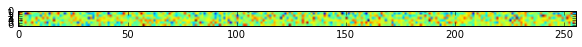

In [5]:
def vis_param(i):
    W = agent.qnet.params[i].eval(agent.qnet.session)
    try:
        plt.figure(figsize=(10, 10))
        fig = plt.imshow(W)
    except:
        pass
    print(np.mean(W))

vis_param(0)

In [6]:
W = agent.qnet.params[4].eval(agent.qnet.session)

cols = np.ones([W.shape[0]]).dot(W)
print(cols)

[ 0.95057295  1.9755205   0.44563068 -0.24171524  1.57289119 -0.36165628
 -1.67348356  0.59209684 -0.08455255 -0.67200055 -0.91248933  1.9515308
 -1.25754121  0.26054316  1.63901423 -0.15200353 -0.53595711  0.03512175
  1.03473613 -0.31521724  1.73942375 -0.10710676  0.42417255  0.27962269
  0.5628927  -0.03457086  0.82630654  0.96461271 -0.22385659 -0.58278088
 -2.24263695 -0.76635291]


In [7]:
agent.qnet.params[2].eval(agent.qnet.session)

array([[ 0.00200493,  0.14719483, -0.11058944, ..., -0.03569595,
        -0.16811188,  0.09979531],
       [ 0.0497968 ,  0.16759649, -0.04565157, ...,  0.02794193,
        -0.00865979,  0.09287517],
       [-0.01413967,  0.11827582, -0.23537861, ...,  0.00447772,
         0.09207478,  0.12868312],
       ..., 
       [ 0.00193084, -0.10813432, -0.10510299, ..., -0.05092666,
        -0.06435387,  0.08844163],
       [ 0.15164572, -0.03377949,  0.109294  , ...,  0.16055968,
         0.04504823,  0.17928302],
       [-0.03034329,  0.02836197, -0.00746052, ..., -0.10741299,
        -0.04490258,  0.04669522]], dtype=float32)

In [8]:
agent.M[0]

{'a1': 20,
 'a2': 31,
 'r': 1,
 's1': array([[-0.89500094,  0.86791729, -0.0650656 ,  0.41586826,  0.10925329,
         -0.23336333,  0.        ]]),
 's2': array([[-0.79926987,  0.95089719, -0.51241841, -0.15325202, -0.12171062,
          0.01137108,  0.        ]])}

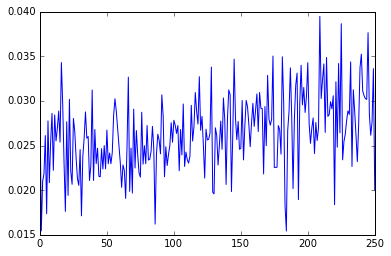

KeyboardInterrupt: 

In [12]:
costs = []
for i in range(1000):
    agent.train(iters=10, batch_size=4, keep_prob=1.0)
    c = agent.test(batch_size=100)
    costs.append(c)
    if i % 10 == 0:
        clear_output(wait=True)
        fig = plt.plot(costs)
        plt.show()

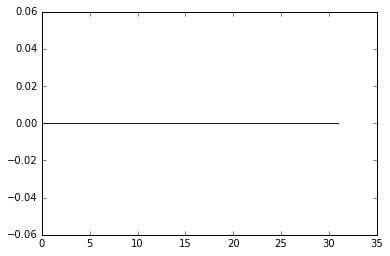

In [19]:
fig = plt.plot(agent.fatigue[0])